In [1]:
def adjacent_edges(nodes, halfk):
    n = len(nodes) # number of nodes
    for i, u in enumerate(nodes): # take a node 
        for j in range(i+1, i+halfk+1): # take the next halfk nodes in the ring
            v = nodes[j % n]
            yield u, v

In [3]:
import networkx as nx

In [4]:
list(adjacent_edges(range(3), 1))

[(0, 1), (1, 2), (2, 0)]

In [5]:
def make_ring_lattice(n, k):
    G = nx.Graph()
    G.add_nodes_from(range(n))
    G.add_edges_from(adjacent_edges(range(n), k//2))
    return G


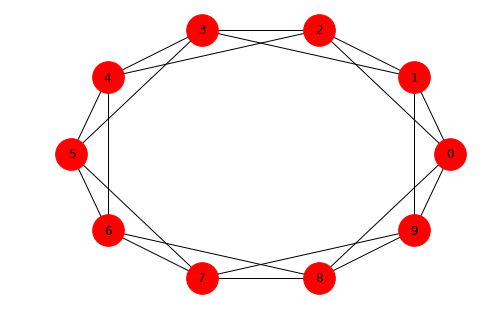

In [7]:
g = make_ring_lattice(10, 4)
nx.draw_circular(g, node_size=1000, node_color='#ff0000', with_labels=True)

In [9]:
import numpy as np
def flip(p):
    return np.random.random() < p

In [79]:
def rewire(G, p):
    nodes = set(G)
    for u, v in G.edges():
        if flip(p):
            choices = nodes - {u} - set(G[u]) # Choices are nodes that aren't the start nodes or an existing edge starting at the same node
            if len(choices) > 0:
                new_v = np.random.choice(list(choices))
                G.remove_edge(u, v)
                G.add_edge(u, new_v)

In [19]:
def draw_ws_graph(n, k, p):
    G = make_ring_lattice(n, k)
    rewire(G, p)
    nx.draw_circular(G, node_size=1000, node_color='#ff0000', with_labels=True)

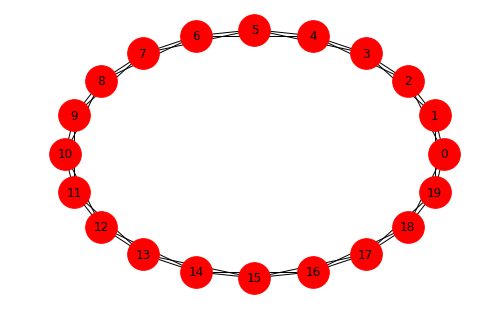

In [20]:
draw_ws_graph(20, 4, 0)

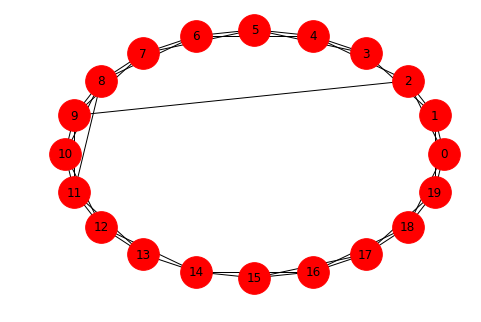

In [22]:
draw_ws_graph(20, 4, 0.2)

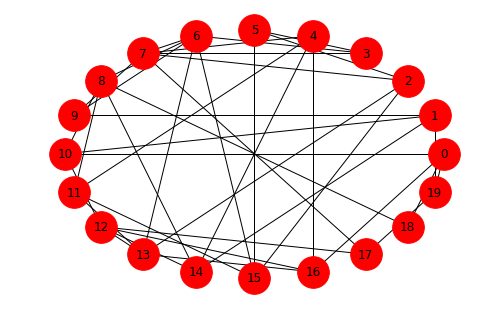

In [23]:
draw_ws_graph(20, 4, 1)

In [28]:
def all_pairs(nodes):
    for i, u in enumerate(nodes):
        for j, v in enumerate(nodes):
            if i < j:
                yield u, v    

def node_clustering(G, u):
    neighbours = G[u]
    k = len(neighbours)
    if k < 2:
        return np.nan # If a node only has 1 neighbour why do we ignore it?
    
    possible = k * (k-1) / 2
    exist = 0
    for v, w in all_pairs(neighbours):
        if G.has_edge(v, w):
            exist += 1
    return exist / possible

In [29]:
lattice = make_ring_lattice(10, 4)
node_clustering(lattice, 1)

0.5

In [30]:
def clustering_coefficient(G):
    cu = [node_clustering(G, n) for n in G]
    return np.nanmean(cu)

In [31]:
clustering_coefficient(lattice)

0.5

In [89]:
def path_lengths(G):
    lengths_map = dict(nx.shortest_path_length(G))
    try:
        lengths = [lengths_map[u][v] for u, v in all_pairs(G)]
        return lengths
    except KeyError as e:
        print(e)
    

In [44]:
def characteristic_path_length(G):
    return np.mean(path_lengths(G))

In [45]:
lattice = make_ring_lattice(3, 2)
characteristic_path_length(lattice)

1.0

In [46]:
def make_ws_graph(n, k, p):
    G = make_ring_lattice(n, k)
    rewire(G, p)
    return G

def run_one_graph(n, k, p):
    ws = make_ws_graph(n, k, p)
    mpl = characteristic_path_length(ws)
    cc = clustering_coefficient(ws)
    return mpl, cc

    

In [57]:
run_one_graph(5, 3, 0.5)

(1.6, 0.0)

In [73]:
def run_experiment(ps, n=1000, k=10, iters=20):
    res = []
    for p in ps:
        t = [run_one_graph(n, k, p) for _ in range(iters)]
        means = np.array(t).mean(axis=0)
        res.append(means)
    return np.array(res)
    

In [98]:
ps = np.logspace(-4, 0, 9)
res = run_experiment(ps, n=300)
L, C = np.transpose(res)
L /= L[0]
C /= C[0]

In [96]:
def decorate(**options):
    """Decorate the current axes.
    Call decorate with keyword arguments like
    decorate(title='Title',
             xlabel='x',
             ylabel='y')
    The keyword arguments can be any of the axis properties
    https://matplotlib.org/api/axes_api.html
    In addition, you can use `legend=False` to suppress the legend.
    And you can use `loc` to indicate the location of the legend
    (the default value is 'best')
    """
    loc = options.pop("loc", "best")
    if options.pop("legend", True):
        legend(loc=loc)

    plt.gca().set(**options)
    plt.tight_layout()

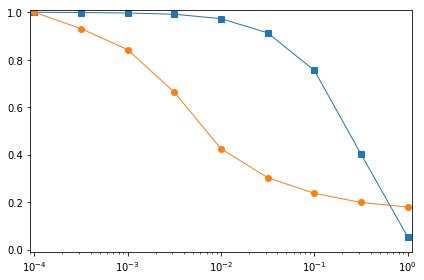

In [99]:
import matplotlib.pyplot as plt
plt.plot(ps, C, 's-', linewidth=1, label='C(p) / C(0)')
plt.plot(ps, L, 'o-', linewidth=1, label='L(p) / L(0)')
options = {'xscale': 'log', 'xlim': [0.00009, 1.1], 'ylim': [-0.01, 1.01]}
plt.gca().set(**options)
plt.tight_layout()
#decorate(xlabel='Rewiring probability (p)', xscale='log',
#         title='Normalized clustering coefficient and path length',
#         xlim=[0.00009, 1.1], ylim=[-0.01, 1.01])

In [1]:
from collections import deque

def reachable_nodes_bfs(G, start):
    seen = set()
    queue = deque([start])
    while queue:
        node = queue.popleft()
        if node not in seen:
            seen.add(node)
            queue.extend(G.neighbours(node))
    return seen